# Install and Setup PyTorch

In [1]:
# Install pytorch and torchvision libraries

!pip install torch torchvision

# Instlal ipywidgets for viewing progress
!pip install ipywidgets

Error processing line 1 of C:\Users\tabit\anaconda3\lib\site-packages\vision-1.0.0-py3.8-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\tabit\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


Error processing line 1 of C:\Users\tabit\anaconda3\lib\site-packages\vision-1.0.0-py3.8-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\tabit\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

In [ ]:
# Stabilize across runs
torch.manual_seed(45)

# Loading Fashion MNIST Dataset

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [7]:
# Training set contains 60,000 images and test set contains 10,000 images

print('Training data:', len(training_data))
print('Test data:', len(test_data))

batch_size = 64

# Create train and test data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# A batch consists of 64 images, each 28x28 pixels
# Each pixel intensity is represented as a byte (0 to 255)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Training data: 60000
Test data: 10000
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


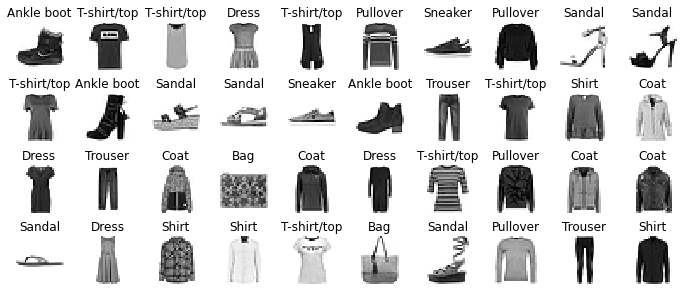

In [8]:
# visualize it

# class names 
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = training_data.__getitem__(index)
        plt.imshow(X[0], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# CNN Model

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import torch.nn.functional


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        # Using the nn.Sequential function, define a 5 layers of convolutions
        self.conv_relu_stack =  nn.Sequential(
            nn.ReLU(), # Activation
            nn.Conv2d(1,32,kernel_size=3,padding = 1), # Layer 1
            nn.Conv2d(32,64,kernel_size=3,padding = 1), # Layer 2
            nn.MaxPool2d(kernel_size=2), # Max Pool
            nn.ReLU() # Relu again
            # Additonal Layers can be changed/added for accuracy tuning.
        )
        
        self.linear = nn.Linear(in_features=12544, out_features=10)
        
        

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x) 
        logits = self.linear(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): ReLU()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
  )
  (linear): Linear(in_features=12544, out_features=10, bias=True)
)


# Loss Function and Optimization for Training the Model

In [12]:
# cross-entropy loss as loss function
loss_fn = nn.CrossEntropyLoss()
# Designated learning rate hyperparam
learning_rate = 1e-2

# stochastic gradient descent (SGD) for optimization
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train and Test Funcs

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # set the model to train mode
    model.train()
    
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # Compute training loss
        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        
        # Calculate model gradients from the loss and optimize the network
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)
        
    return np.array(losses).mean()

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Set the model to eval mode
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():	# no_grad mode doesn't compute gradients
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

# Run Train and Test

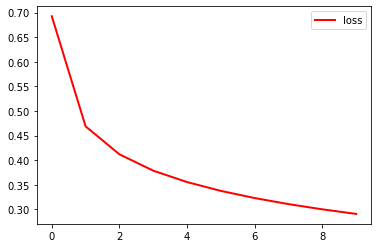

<ipython-input-15-051091e7e5ef>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure()


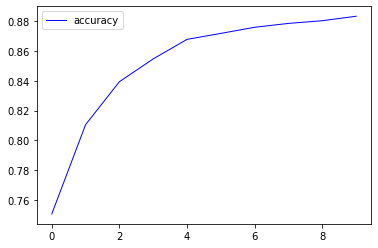

End Iterations: Run Finished


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

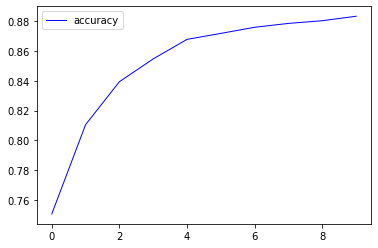

In [15]:
epochs = 10

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("End Iterations: Run Finished")

# Model Predictions

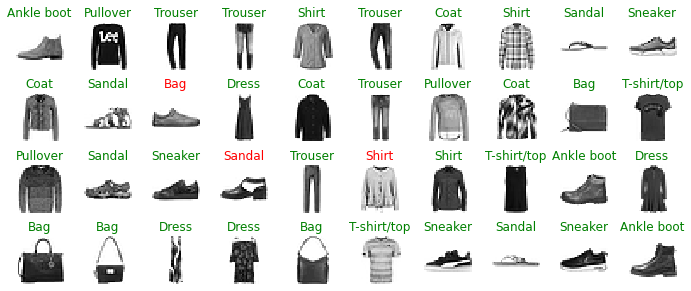

In [16]:
# Make predictions on the first 40 test data items using the trained model and visualize them
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = test_data.__getitem__(index)
        y_pred = model(X.to(device)[None,...])
        y_pred = y_pred.argmax(1)
        plt.imshow(X[0], cmap="binary", interpolation="nearest")
        plt.axis('off')
        if y == y_pred:
            plt.title(class_names[y_pred], fontsize=12, color='g')
        else:
            plt.title(class_names[y_pred], fontsize=12, color='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()